In [59]:
# Importing the necessary libraries
import os
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial.distance import cdist

In [33]:
# Downloading the dataset
path = kagglehub.dataset_download("anokas/kuzushiji")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/anokas/kuzushiji/versions/3


In [34]:
# Defining the dataset path
dataset_path = '/root/.cache/kagglehub/datasets/anokas/kuzushiji/versions/3'

# Listing the files in the dataset directory
print(os.listdir(dataset_path))

['k49-test-labels.npz', 't10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz', 'kmnist-train-imgs.npz', 'kmnist_classmap.csv', 'train-labels-idx1-ubyte', 't10k-labels-idx1-ubyte', 'k49_classmap.csv', 'kmnist-train-labels.npz', 'train-images-idx3-ubyte', 'kkanji.tar', 'k49-test-imgs.npz', 'train-images-idx3-ubyte.gz', 'k49-train-labels.npz', 'k49-train-imgs.npz', 'kmnist-test-labels.npz', 'kkanji', 't10k-images-idx3-ubyte.gz', 'kmnist-test-imgs.npz']


In [35]:
# Loading the dataset
train_images = np.load(os.path.join(dataset_path, 'kmnist-train-imgs.npz'))['arr_0']
train_labels = np.load(os.path.join(dataset_path, 'kmnist-train-labels.npz'))['arr_0']
test_images = np.load(os.path.join(dataset_path, 'kmnist-test-imgs.npz'))['arr_0']
test_labels = np.load(os.path.join(dataset_path, 'kmnist-test-labels.npz'))['arr_0']

In [36]:
# Normalizing pixel values between 0 and 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [37]:
# Flattening the images for input into the RBF network (28x28 -> 784 features)
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

In [38]:
# Splitting the dataset into 80% training and 20% validation/testing
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

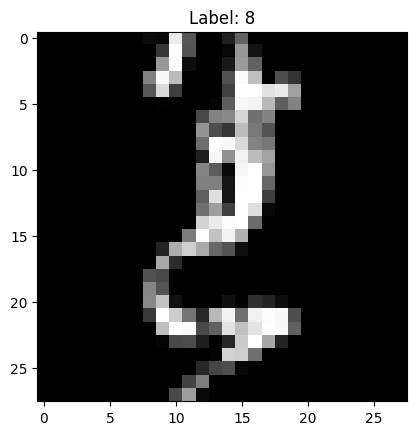

In [13]:
plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.show()

In [39]:
# Helper function to compute Gaussian RBF
def gaussian_rbf(X, centers, sigma):
    return np.exp(-cdist(X, centers) ** 2 / (2 * sigma ** 2))

In [49]:
# One-hot encoding the labels
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_val_onehot = onehot_encoder.transform(y_val.reshape(-1, 1))

In [42]:
# Defining the number of RBF units (centers)
n_rbf_units = 100

In [43]:
# Step 1: K-Means clustering to find RBF centers
kmeans = KMeans(n_clusters=n_rbf_units, random_state=42)
kmeans.fit(X_train)
centers = kmeans.cluster_centers_

In [44]:
# Step 2: Computing the RBF hidden layer output for training and validation sets
sigma = np.mean([np.linalg.norm(centers[i] - centers[j]) for i in range(n_rbf_units) for j in range(n_rbf_units)])
X_train_rbf = gaussian_rbf(X_train, centers, sigma)
X_val_rbf = gaussian_rbf(X_val, centers, sigma)

In [51]:
# Step 3: Defining the output layer (softmax)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_rbf_units,)),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.build(input_shape=(None, n_rbf_units))

# Compiling the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [52]:
# Step 4: Training the network
history = model.fit(X_train_rbf, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_val_rbf, y_val_onehot))

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4942 - loss: 1.6165 - val_accuracy: 0.6973 - val_loss: 1.0332
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6955 - loss: 0.9981 - val_accuracy: 0.7214 - val_loss: 0.9087
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7268 - loss: 0.8790 - val_accuracy: 0.7547 - val_loss: 0.8212
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7475 - loss: 0.8182 - val_accuracy: 0.7582 - val_loss: 0.7754
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7536 - loss: 0.7850 - val_accuracy: 0.7626 - val_loss: 0.7497
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7601 - loss: 0.7565 - val_accuracy: 0.7570 - val_loss: 0.7541
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7718 - loss: 0.7299 - val_accuracy: 0.7797 - val_loss: 0.7044
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7772 - loss: 0.7123 - 

In [53]:
# Computing RBF hidden layer output for the test set
X_test_rbf = gaussian_rbf(test_images, centers, sigma)

In [54]:
# Evaluating the model on the test set
y_test_onehot = onehot_encoder.transform(test_labels.reshape(-1, 1))
test_loss, test_acc = model.evaluate(X_test_rbf, y_test_onehot)

print(f"Test Accuracy: {test_acc * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6430 - loss: 1.1246
Test Accuracy: 63.29%


In [55]:
# Getting predictions for confusion matrix
y_pred = model.predict(X_test_rbf)
y_pred_labels = np.argmax(y_pred, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


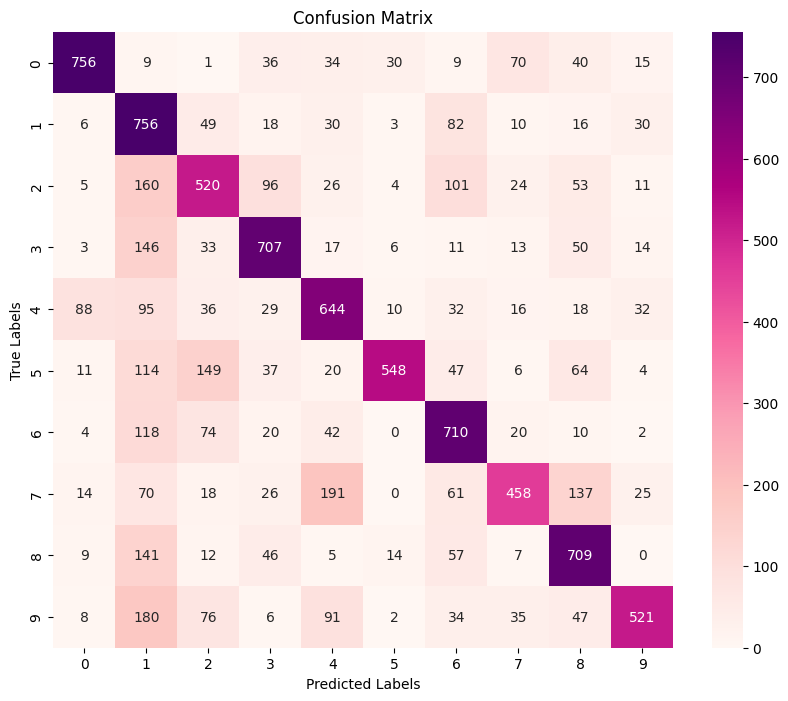

In [63]:
# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', cbar=True)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [65]:
# Printing the classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.41      0.45      1000
           1       0.26      0.41      0.32      1000
           2       0.14      0.09      0.11      1000
           3       0.25      0.16      0.20      1000
           4       0.21      0.35      0.26      1000
           5       0.24      0.22      0.23      1000
           6       0.19      0.33      0.24      1000
           7       0.20      0.10      0.13      1000
           8       0.11      0.15      0.13      1000
           9       0.20      0.02      0.04      1000

    accuracy                           0.22     10000
   macro avg       0.23      0.22      0.21     10000
weighted avg       0.23      0.22      0.21     10000



**Strengths of RBF Network for this dataset:**
- Good at capturing local features, which can be beneficial for character recognition.
- Can handle non-linear decision boundaries effectively.
- With the use of Gaussian functions, the network becomes simpler compared to deeper architectures.
- Training process is relatively fast compared to some other neural network architectures.

**Limitations:**
- May require a large number of hidden units for complex patterns, leading to increased computational cost.
- Training becomes inefficient with large datasets due to the computation of distances between the input and the centers.
- Performance heavily depends on the choice of RBF centers and widths.
- Can be sensitive to the curse of dimensionality.

**Impact of RBF units on model performance:**
- Too few units: May not capture the complexity of the data, leading to underfitting.
- Too many units: Can lead to overfitting that eventually results in poor generalization to unseen data and increased computational cost.
- Optimal number: Balances between model complexity and generalization ability.

**To find the optimal number of RBF units, we can:**
- Use cross-validation to test different numbers of hidden units.
- Implement a growing/pruning algorithm to dynamically adjust the number of units during training.
- Use techniques like Bayesian Optimization to find the optimal hyperparameters, including the number of RBF units.